<a href="https://colab.research.google.com/github/aletcher/stable-opponent-shaping/blob/master/stable_opponent_shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proof-of-concept implementation of Stable Opponent Shaping ([SOS](https://openreview.net/pdf?id=SyGjjsC5tQ)). Feel free to define any n-player game and compare SOS with other learning algorithms including Naive Learning (NL), [LOLA](https://arxiv.org/pdf/1709.04326.pdf), [LA](https://openreview.net/pdf?id=SyGjjsC5tQ), [CO](https://arxiv.org/pdf/1705.10461.pdf), [SGA](http://jmlr.csail.mit.edu/papers/volume20/19-008/19-008.pdf), [CGD](https://arxiv.org/pdf/1905.12103.pdf), [EG](https://arxiv.org/pdf/1906.05945.pdf) and [LSS](https://arxiv.org/pdf/1901.00838.pdf).

In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [0]:
#@markdown Game definitions for matching pennies, iterated prisoner's
#@markdown dilemma and tandem (define your own here).

def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
    L_1 = torch.matmul(torch.matmul(x, payout_mat_1), y)
    L_2 = torch.matmul(torch.matmul(x, payout_mat_2), y)
    return [L_1, L_2]
  return dims, Ls

def ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = torch.Tensor([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = torch.sigmoid(th[0][0:1])
    p_2_0 = torch.sigmoid(th[1][0:1])
    p = torch.cat([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)])
    p_1 = torch.reshape(torch.sigmoid(th[0][1:5]), (4, 1))
    p_2 = torch.reshape(torch.sigmoid(th[1][1:5]), (4, 1))
    P = torch.cat([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], dim=1)
    M = -torch.matmul(p, torch.inverse(torch.eye(4)-gamma*P))
    L_1 = torch.matmul(M, torch.reshape(payout_mat_1, (4, 1)))
    L_2 = torch.matmul(M, torch.reshape(payout_mat_2, (4, 1)))
    return [L_1, L_2]
  return dims, Ls

def tandem():
  dims = [1, 1]
  def Ls(th):
    x, y = th
    L_1 = (x+y)**2-2*x
    L_2 = (x+y)**2-2*y
    return [L_1, L_2]
  return dims, Ls

In [0]:
#@markdown Gradient computations for each algorithm.

def init_th(dims, std):
  th = []
  for i in range(len(dims)):
    if std > 0:
      init = torch.nn.init.normal_(torch.empty(dims[i], requires_grad=True), std=std)
    else:
      init = torch.zeros(dims[i], requires_grad=True)
    th.append(init)
  return th

def get_gradient(function, param):
  grad = torch.autograd.grad(function, param, create_graph=True)[0]
  return grad

def get_hessian(th, grad_L, diag=True, off_diag=True):
  n = len(th)
  H = []
  for i in range(n):
    row_block = []
    for j in range(n):
      if (i == j and diag) or (i != j and off_diag):
        block = [torch.unsqueeze(get_gradient(grad_L[i][i][k], th[j]), dim=0) 
                  for k in range(len(th[i]))]
        row_block.append(torch.cat(block, dim=0))
      else:
        row_block.append(torch.zeros(len(th[i]), len(th[j])))
    H.append(torch.cat(row_block, dim=1))
  return torch.cat(H, dim=0)

def update_th(th, Ls, alpha, algo, a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1):
  n = len(th)
  losses = Ls(th)

  # Compute gradients
  grad_L = [[get_gradient(losses[j], th[i]) for j in range(n)] for i in range(n)]
  if algo == 'la':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'lola':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j])
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*get_gradient(terms[i], th[i]) for i in range(n)]
  elif algo == 'sos':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    xi_0 = [grad_L[i][i]-alpha*get_gradient(terms[i], th[i]) for i in range(n)]
    chi = [get_gradient(sum([torch.dot(grad_L[j][i].detach(), grad_L[j][j])
              for j in range(n) if j != i]), th[i]) for i in range(n)]
    # Compute p
    dot = torch.dot(-alpha*torch.cat(chi), torch.cat(xi_0))
    p1 = 1 if dot >= 0 else min(1, -a*torch.norm(torch.cat(xi_0))**2/dot)
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    xi_norm = torch.norm(xi)
    p2 = xi_norm**2 if xi_norm < b else 1
    p = min(p1, p2)
    grads = [xi_0[i]-p*alpha*chi[i] for i in range(n)]
  elif algo == 'sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    H_t_xi = [get_gradient(ham, th[i]) for i in range(n)]
    H_xi = [get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    # Compute lambda (sga with alignment)
    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))
    d = sum([len(th[i]) for i in range(n)])
    lam = torch.sign(dot_xi*dot_A/d+ep)
    grads = [grad_L[i][i]+lam*A_t_xi[i] for i in range(n)]
  elif algo == 'co':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    grads = [grad_L[i][i]+gam*get_gradient(ham, th[i]) for i in range(n)]
  elif algo == 'eg':
    th_eg = [th[i]-alpha*get_gradient(losses[i], th[i]) for i in range(n)]
    losses_eg = Ls(th_eg)
    grads = [get_gradient(losses_eg[i], th_eg[i]) for i in range(n)]
  elif algo == 'cgd': # Slow implementation (matrix inversion)
    dims = [len(th[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H_o = get_hessian(th, grad_L, diag=False)
    grad = torch.matmul(torch.inverse(torch.eye(sum(dims))+alpha*H_o), xi)
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]
  elif algo == 'lss': # Slow implementation (matrix inversion)
    dims = [len(th[i]) for i in range(n)]
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    H = get_hessian(th, grad_L)
    if torch.det(H) == 0:
      inv = torch.inverse(torch.matmul(H.T, H)+lss_lam*torch.eye(sum(dims)))
      H_inv = torch.matmul(inv, H.T)
    else:
      H_inv = torch.inverse(H)
    grad = torch.matmul(torch.eye(sum(dims))+torch.matmul(H.T, H_inv), xi)/2
    grads = [grad[sum(dims[:i]):sum(dims[:i+1])] for i in range(n)]
  else: # Naive Learning
    grads = [grad_L[i][i] for i in range(n)]

  # Update theta
  with torch.no_grad():
    for i in range(n):
      th[i] -= alpha*grads[i]
  return th, losses

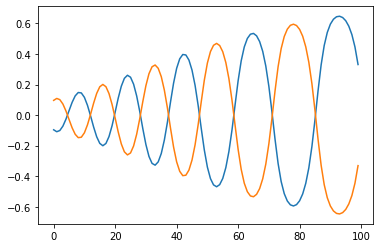

In [25]:
'''Run SOS on the game of your choosing below'''

# Select game
dims, Ls = matching_pennies()

# Set num_epochs, learning rate and learning algo
num_epochs = 100
alpha = 1
algo = 'nl'  #('sos', 'lola', 'la', 'sga', 'co', 'eg', 'cgd', 'lss' or 'nl')

# Initialise theta ~ Normal(0, std)
std = 1
th = init_th(dims, std)

# Run
losses_out = np.zeros((num_epochs, len(th)))
for k in range(num_epochs):
  th, losses = update_th(th, Ls, alpha, algo)
  losses_out[k] = [loss.data.numpy() for loss in losses]
plt.plot(losses_out)
plt.show()

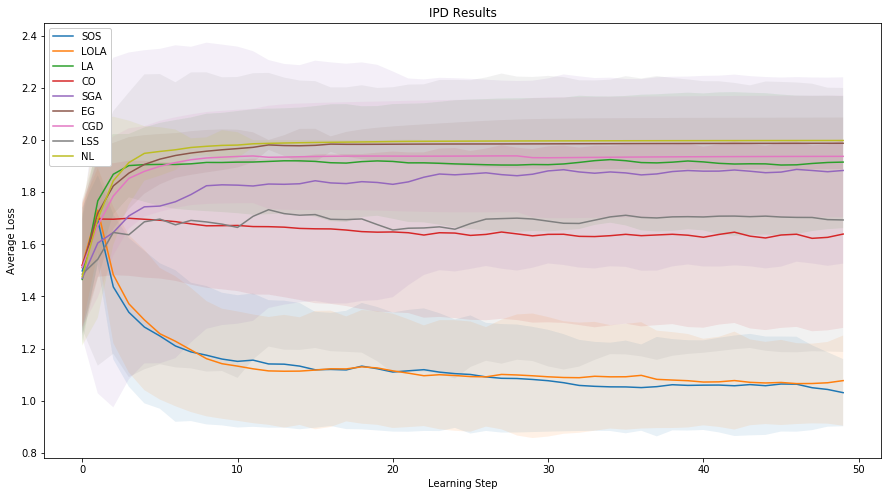

In [26]:
'''Iterated Prisoner's Dilemma - SOS/LOLA vs LA/CO/SGA/EG/CGD/LSS/NL'''

gamma = 0.96
dims, Ls = ipd(gamma)

num_runs = 100
num_epochs = 50
alpha = 1
std = 1

plt.figure(figsize=(15, 8))
for algo in ['sos', 'lola', 'la', 'co', 'sga', 'eg', 'cgd', 'lss', 'nl']:
  losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    th = init_th(dims, std)
    for k in range(num_epochs):
      th, losses = update_th(th, Ls, alpha, algo)
      losses_out[i, k] = (1-gamma)*losses[0].data.numpy()

  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.1)

plt.title('IPD Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['SOS', 'LOLA', 'LA', 'CO', 'SGA', 'EG', 'CGD', 'LSS', 'NL'], loc='best', frameon=True, framealpha=1)
plt.show()

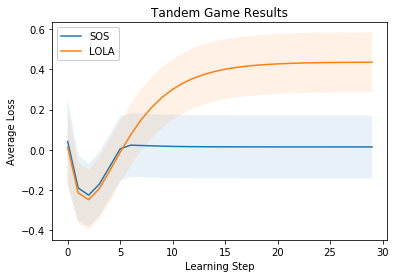

In [27]:
'''Tandem Game - SOS vs LOLA'''

dims, Ls = tandem()

num_runs = 100
num_epochs = 30
alpha = 0.1
std = 0.1

for algo in ['sos', 'lola']:
  losses_out = np.zeros((num_runs, num_epochs))
  for i in range(num_runs):
    th = init_th(dims, std)
    for k in range(num_epochs):
      th, losses = update_th(th, Ls, alpha, algo)
      losses_out[i, k] = losses[0].data.numpy()

  mean = np.mean(losses_out, axis=0)
  dev = np.std(losses_out, axis=0)
  plt.plot(np.arange(num_epochs), mean)
  plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.1)

plt.title('Tandem Game Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['SOS', 'LOLA'], loc='upper left', frameon=True, framealpha=1)
plt.show()